<a href="https://colab.research.google.com/github/marcosmedvescig/survival_models_applied_to_churn_prediction/blob/master/Employee_retention_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of using survival models for Employee Retention

This example is just a simple illustration on how survival models can be applied tu understand and predict when employees will quit a company.

This is a simple example were the objective in just use it as a proof of concept. Therefore, we are using a test dataset included in the pytorch library and we don't work on feature engineering besides preparing the data for training and testing a model.



## Seting up the environment


In [2]:
# Install libraries
!pip install pysurvival

     |████████████████████████████████| 4.8MB 2.8MB/s 
  Created wheel for pysurvival: filename=pysurvival-0.1.2-cp36-cp36m-linux_x86_64.whl size=3774923 sha256=c77f698f2c26f311e0d874b4efa471dc11f6b5ac5605fc7d3729431fe5d69b86
  Stored in directory: /root/.cache/pip/wheels/6c/23/e8/6feb0c4432219666bdd5d33828d7d9f429c4726f34c6fa8061
  Created wheel for progressbar: filename=progressbar-2.5-cp36-none-any.whl size=12074 sha256=56add95e71c8c7ae51aca19353680ff80158240c80d326174e66bd658e39ac6c
  Stored in directory: /root/.cache/pip/wheels/c0/e9/6b/ea01090205e285175842339aa3b491adeb4015206cda272ff0
Successfully built pysurvival progressbar


In [6]:
# Import modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pysurvival.datasets import Dataset
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Data overview

For this example we are using an example dataset included in the pytorch library just designed for this case.

The dataset have 9 features in total, 7 numeric and 2 categorical. The latter we will convert to numerical using the on-hot encoding technique.

In [7]:
# Read the dataset
raw_dataset = Dataset('employee_attrition').load()

In [4]:
# Dataset structure, features and data types
raw_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_projects        14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
# Peek at the data 
raw_dataset.head()

,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


## Feature Engineering

### Prepare the data for the survival model

In [8]:
# Creating the time and event columns
time_column = 'time_spend_company'
event_column = 'left'

In [9]:
# Create one-hot vectors
category_columns = ['department', 'salary']
dataset = pd.get_dummies(raw_dataset, columns=category_columns, drop_first=True)
dataset.head()

,satisfaction_level,last_evaluation,number_projects,average_montly_hours,time_spend_company,work_accident,left,promotion_last_5years,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,0,0,0,0,0,0,1,0,0,1,0


In [10]:
# Create the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

In [11]:
# Check for null values
N_null = sum(dataset[features].isnull().sum())
print("The dataset contains {} null values".format(N_null)) #0 null values

# Remove duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The dataset contains {} duplicates".format(N_dupli))

The dataset contains 0 null values
The dataset contains 3008 duplicates


In [21]:
# Create Train, Test, Eval dataset

from sklearn.model_selection import train_test_split

# Defining the features
X = pd.get_dummies(dataset.drop([time_column, event_column], axis=1))
T = dataset[time_column]
E = dataset[event_column]

## Create evaluation set, 70% of the data.
index_train_test, index_eval = train_test_split( range(len(X)), test_size = 0.7, random_state = 2020)

# Creating the X, T and E input
X_train_test = X.loc[index_train_test].reset_index( drop = True )
X_eval  = X.loc[index_eval].reset_index( drop = True )

T_train_test = T.loc[index_train_test].reset_index( drop = True )
T_eval  = T.loc[index_eval].reset_index( drop = True )

E_train_test = E.loc[index_train_test].reset_index( drop = True )
E_eval  = E.loc[index_eval].reset_index( drop = True )


## Create train and test set, 30% of the data.
index_train, index_test = train_test_split( range(len(X_train_test)), test_size = 0.25, random_state = 2020)

# Creating the X, T and E input
X_train = X_train_test.loc[index_train].reset_index( drop = True )
X_test  = X_train_test.loc[index_test].reset_index( drop = True )

T_train = T_train_test.loc[index_train].reset_index( drop = True )
T_test  = T_train_test.loc[index_test].reset_index( drop = True )

E_train = E_train_test.loc[index_train].reset_index( drop = True )
E_test  = E_train_test.loc[index_test].reset_index( drop = True )

## Train the model

In [22]:
from pysurvival.models.survival_forest import ConditionalSurvivalForestModel

# Fit the model
csf = ConditionalSurvivalForestModel(num_trees=200)
csf.fit(X_train, T_train, E_train, max_features='sqrt',
        alpha=0.05, minprop=0.1, max_depth=5, min_node_size=30)

ConditionalSurvivalForestModel

## Test the model

### Feature importance

In [23]:
# TOP 5 features
csf.variable_importance_table.head(5)

,feature,importance,pct_importance
0,number_projects,7.793862,0.232904
1,satisfaction_level,7.770623,0.232210
2,average_montly_hours,5.057413,0.151131
3,work_accident,4.011365,0.119872
4,salary_low,3.813634,0.113963


### C-Index

In [27]:
# Calculate c-index score

from pysurvival.utils.metrics import concordance_index
c_index = concordance_index(csf, X_eval, T_eval, E_eval)
print('C-index: {:.2f}'.format(c_index))

C-index: 0.91


### Brier Score

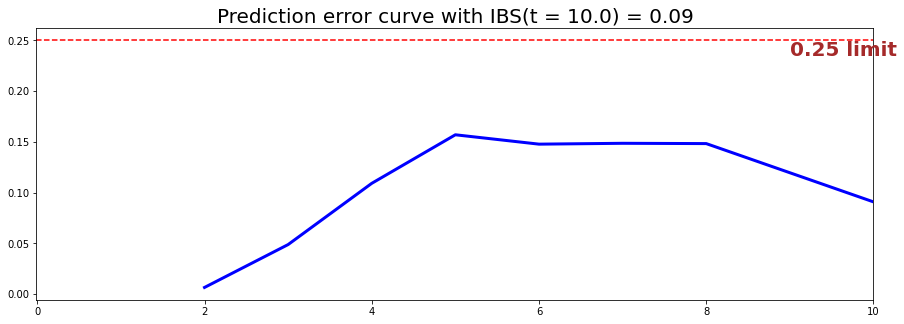

IBS: 0.09


In [29]:
# Calculate Brier Score

from pysurvival.utils.display import integrated_brier_score
ibs = integrated_brier_score(csf, X_eval, T_eval, E_eval, t_max=12,
    figure_size=(15,5))
print('IBS: {:.2f}'.format(ibs))

## Predictions

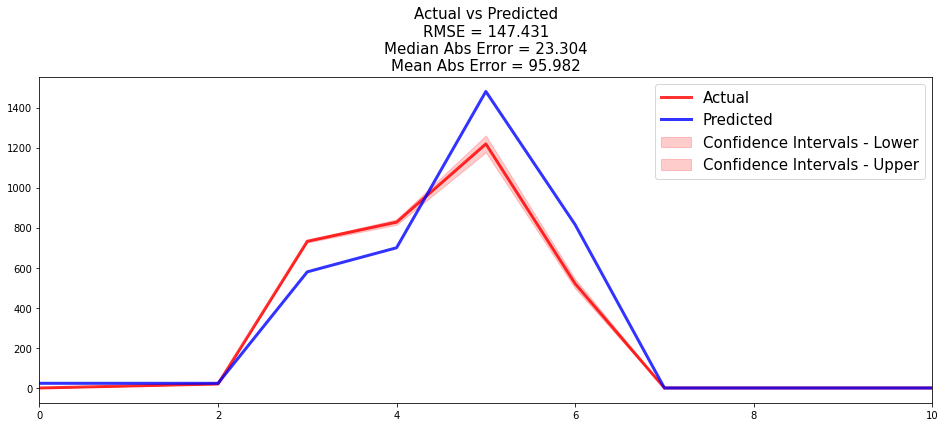

In [26]:
# Predict and compare to evaluation data

from pysurvival.utils.display import compare_to_actual
results = compare_to_actual(csf, X_eval, T_eval, E_eval,
                            is_at_risk = False,  figure_size=(16, 6),
                            metrics = ['rmse', 'mean', 'median'])